<a href="https://colab.research.google.com/github/annguyen1404/JSC270A4/blob/main/JSC270_A4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import io 
from textblob import TextBlob
import tweepy
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from statsmodels.gam.api import GLMGam, BSplines

import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

auth = tweepy.OAuthHandler("03VF15CpkFRrR3bQW5reuvxPj", "UkmCU6PbjZgOkCMgrrpbBYiO3llAptA4Enm78NqhMzLtZBfYTv")
auth.set_access_token("1376701637922816008-Ndna5uC6yfIlSi0e0EcPQm0Gj7jGai", "6KuJvWaF8ozjJdlcVcgXM9Ft5lubC4JyHk83NqA0aKgdr")
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Q1. 

In [ ]:
# Import data
train_file = files.upload()
test_file = files.upload()

Saving covid-tweets-train.csv to covid-tweets-train (1).csv


Saving covid-tweets-test.csv to covid-tweets-test (1).csv


In [ ]:
# Read loaded data in as pandas df  
train_data = pd.read_csv(io.BytesIO(train_file['covid-tweets-train.csv']), encoding = 'utf-8') 
test_data = pd.read_csv(io.BytesIO(test_file['covid-tweets-test.csv']), encoding = 'utf-8') 

In [ ]:
# Drop columns that we dont need
train_data = train_data.drop(['Unnamed: 0'], axis = 1)
test_data = test_data.drop(['Unnamed: 0'], axis = 1)
# Rename columns
train_data.columns = ['tweet', 'label']
test_data.columns = ['tweet', 'label']

In [ ]:
# Remove rows with missing sentiment and convert sentiment column to int
if (train_data.label.dtype != int):
  train_data = train_data.drop(train_data[((train_data.label != '0') & (train_data.label != '1') & (train_data.label != '2'))].index)
  train_data['label'] = (train_data['label']).astype(int)
if (test_data.label.dtype != int):
  test_data = test_data.drop(test_data[((test_data.sentiment != '0') & (test_data.label != '1') & (test_data.label != '2'))].index)
  test_data['label'] = (test_data['label']).astype(int)


### Q1A.

In [ ]:
# Proportion of sentiments in train data
N = len(train_data)
sen_prop = train_data.groupby('label').count()/N
sen_prop.columns = ["proportions"]
sen_prop


,proportions
label,
0,0.374159
1,0.187407
2,0.438434


### Q1B.

In [ ]:
# Tokenize the tweets

import nltk
# Download the tokenizer
nltk.download('punkt')
# Create a new column in data for token lists
train_data['tokens'] = train_data['tweet'].apply(nltk.word_tokenize)
test_data['tokens'] = test_data['tweet'].apply(nltk.word_tokenize)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Q1C.

In [ ]:
# Using a regular expression, remove any URL tokens from each of the observations

import re

url = 'http'

tokens_no_url = []
# Create a list of lists with what we want
for row in train_data['tokens']:
  new_row = []
  for string in row:
    if re.match(url, string) is None:
      new_row.append(string)
  tokens_no_url.append(new_row)
# add the new info to our df
train_data['tokens_no_url'] = tokens_no_url

tokens_no_url = []
# Create a list of lists with what we want
for row in test_data['tokens']:
  new_row = []
  for string in row:
    if re.match(url, string) is None:
      new_row.append(string)
  tokens_no_url.append(new_row)
# add the new info to our df
test_data['tokens_no_url'] = tokens_no_url

### Q1D. 
Q: Can you think of a scenario when you might want to keep some forms of punctuation?

We may want to keep punctuations such as the ampersands (@) as it signifies that the next word is a username (when working with twitter tweets). Other punctuations such as $ or % can also contribute to the meaning of a sentence-.

Further, if we want to do Natural Language Generation, we would want to keep punctuations since they are intregral to a sentence's structure.

In [ ]:
# Remove all punctuation (,.?!;:’") and special characters(@, #, +, &, =, $, etc). 
# Also, convert all tokens to lowercase only.
tokens_no_punct_lower = []
# Create a list of lists with what we want
for row in train_data['tokens_no_url']:
  tokens_no_punct_lower.append([re.sub('[^\w\s]','', t.lower()) for t in row])
# add the new info to our df
train_data['tokens_no_punct_lower'] = tokens_no_punct_lower

tokens_no_punct_lower = []
# Create a list of lists with what we want
for row in test_data['tokens_no_url']:
  tokens_no_punct_lower.append([re.sub('[^\w\s]','', t.lower()) for t in row])
# add the new info to our df
test_data['tokens_no_punct_lower'] = tokens_no_punct_lower

### Q1E.

In [ ]:
# Stem our tokens using the Porter stemmer.

from nltk.stem.porter import *

stemmer = PorterStemmer()

stemmed_tokens = []
for row in train_data['tokens_no_punct_lower']:
  stemmed_tokens.append([stemmer.stem(t) for t in row])

train_data['tokens_stem'] = stemmed_tokens

stemmed_tokens = []
for row in test_data['tokens_no_punct_lower']:
  stemmed_tokens.append([stemmer.stem(t) for t in row])

test_data['tokens_stem'] = stemmed_tokens

### Q1F.

In [ ]:
# Remove stopwords
from nltk.corpus import stopwords
nltk.download('stopwords')


# First 100 stopwords in list
sw = stopwords.words('english')[:100]

tokens_no_sw = []
for row in train_data['tokens_stem']:
  tokens_no_sw.append([w for w in row if w not in sw])

train_data['tokens_no_sw'] = tokens_no_sw

tokens_no_sw = []
for row in test_data['tokens_stem']:
  tokens_no_sw.append([w for w in row if w not in sw])

test_data['tokens_no_sw'] = tokens_no_sw

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Q1G. 

The matrix of counts for the training dataset is 41151 by 1000- where 41151 is the number of tweets and 1000 is the word count. Hence, the length of our vocabulary is 1000.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer


def override_fcn(doc):
  # We expect a list of tokens as input
  return doc

# Count Vectorizer
count_vec = CountVectorizer(
    analyzer='word',
    tokenizer= override_fcn,
    preprocessor= override_fcn,
    token_pattern= None,
    max_features = 1000)


# Separate labels from features, converting to numpy arrays
X_train, y_train = train_data['tokens_no_sw'].to_numpy(), train_data['label'].to_numpy()
X_test, y_test = test_data['tokens_no_sw'].to_numpy(), test_data['label'].to_numpy()

counts_train = count_vec.fit_transform(X_train)
counts_test = count_vec.transform(X_test)

print(counts_train.shape)

(41151, 1000)


### Q1H.

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, roc_curve

# Naive Bayes model
nb = MultinomialNB()
# Fit model to count vectors of training data
nb.fit(counts_train, y_train)

# Predict on training and test data
y_train_preds = nb.predict(counts_train)
y_test_preds = nb.predict(counts_test)

print('Train accuracy with simple Naive Bayes:',accuracy_score(y_train,y_train_preds))
print('Test accuracy with simple Naive Bayes:',accuracy_score(y_test,y_test_preds))

Train accuracy with simple Naive Bayes: 0.667079779349226
Test accuracy with simple Naive Bayes: 0.6600842548709848


In [ ]:
# Report the 5 most probable words in each class, along with their counts
word_count = counts_train.sum(axis=0)

for i in range(3):
    sorted_idx = set(np.argsort(nb.feature_log_prob_[i])[-5:])
    print("\nLabel {}".format(i))

    for word in count_vec.get_feature_names():
      idx = count_vec.vocabulary_[word]
      if (idx in sorted_idx):
        log_prob = nb.feature_log_prob_[i][idx]
        print("Word:{} \tCount:{} \tLog Probability:{}\t Probability:{}".format(word, word_count[0,idx], log_prob, np.exp(log_prob)))





Label 0
Word: 	Count:255620 	Log Probability:-1.3138669971285335	 Probability:0.26877867780312087
Word:coronaviru 	Count:18059 	Log Probability:-3.9129161792365235	 Probability:0.019982144499052376
Word:covid19 	Count:12857 	Log Probability:-4.292086147990478	 Probability:0.013676364596278832
Word:food 	Count:7230 	Log Probability:-4.528821982585024	 Probability:0.010793383380147183
Word:price 	Count:9047 	Log Probability:-4.351275019380809	 Probability:0.012890366630975442

Label 1
Word: 	Count:255620 	Log Probability:-0.9976501304472087	 Probability:0.3687449263597359
Word:coronaviru 	Count:18059 	Log Probability:-3.5886054933345424	 Probability:0.027636843325988623
Word:covid19 	Count:12857 	Log Probability:-3.9842838723209653	 Probability:0.01860576365534037
Word:store 	Count:8192 	Log Probability:-4.463916886655389	 Probability:0.011517163400208748
Word:supermarket 	Count:7744 	Log Probability:-4.560990735347211	 Probability:0.010451698944682827

Label 2
Word: 	Count:255620 	Log 

### Q1J.

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, roc_curve

# Part G: TFIDF
tfidf = TfidfTransformer()
tfs_train = tfidf.fit_transform(counts_train)
tfs_test = tfidf.transform(counts_test)

X_train = tfs_train.toarray()
X_test = tfs_test.toarray()


# Part H: Naive Bayes model
nb = MultinomialNB()
# Fit model to training data
nb.fit(X_train, y_train)
# Predict on test data
y_train_preds = nb.predict(X_train)
y_test_preds = nb.predict(X_test)

print('Train accuracy with simple Naive Bayes:',accuracy_score(y_train,y_train_preds))
print('Test accuracy with simple Naive Bayes:',accuracy_score(y_test,y_test_preds))

Train accuracy with simple Naive Bayes: 0.6585988189837428
Test accuracy with simple Naive Bayes: 0.6532385466034755


In [ ]:
# Report the 5 most probable words in each class, along with their counts
word_count = counts_train.sum(axis=0)

for i in range(3):
    sorted_idx = set(np.argsort(nb.feature_log_prob_[i])[-5:])
    print("\nLabel {}".format(i))

    for word in count_vec.get_feature_names():
      idx = count_vec.vocabulary_[word]
      if (idx in sorted_idx):
        log_prob = nb.feature_log_prob_[i][idx]
        print("Word:{} \tCount:{} \tLog Probability:{}".format(word, word_count[0,idx], log_prob))


Label 0
Word: 	Count:255620 	Log Probability:-2.4438990191074126
Word:coronaviru 	Count:18059 	Log Probability:-4.512890825710254
Word:covid19 	Count:12857 	Log Probability:-4.7163975794611135
Word:food 	Count:7230 	Log Probability:-4.74151774842782
Word:price 	Count:9047 	Log Probability:-4.608716280237829

Label 1
Word: 	Count:255620 	Log Probability:-2.0886927713703205
Word:coronaviru 	Count:18059 	Log Probability:-4.06037115339
Word:covid19 	Count:12857 	Log Probability:-4.264195376995263
Word:store 	Count:8192 	Log Probability:-4.529476973219568
Word:supermarket 	Count:7744 	Log Probability:-4.598951494243385

Label 2
Word: 	Count:255620 	Log Probability:-2.391824072585525
Word:coronaviru 	Count:18059 	Log Probability:-4.5910210214078635
Word:covid19 	Count:12857 	Log Probability:-4.710604292078139
Word:store 	Count:8192 	Log Probability:-4.8856641795510685
Word:thi 	Count:7962 	Log Probability:-4.937911941559693


### Q1K.

In [ ]:
# Part E: Lemmatize
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

lemmatized_tokens = []
for row in train_data['tokens_no_punct_lower']:
  lemmatized_tokens.append([lemmatizer.lemmatize(t) for t in row])

train_data['tokens_lemmatized'] = lemmatized_tokens

lemmatized_tokens = []
for row in test_data['tokens_no_punct_lower']:
  lemmatized_tokens.append([lemmatizer.lemmatize(t) for t in row])

test_data['tokens_lemmatized'] = stemmed_tokens

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Part F: Remove stopwords
from nltk.corpus import stopwords
nltk.download('stopwords')


# First 100 stopwords in list
sw = stopwords.words('english')[:100]

tokens_no_sw = []
for row in train_data['tokens_lemmatized']:
  tokens_no_sw.append([w for w in row if w not in sw])

train_data['tokens_no_sw_lemma'] = tokens_no_sw

tokens_no_sw = []
for row in test_data['tokens_lemmatized']:
  tokens_no_sw.append([w for w in row if w not in sw])

test_data['tokens_no_sw_lemma'] = tokens_no_sw

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Part G: Count vectorize + TFIDF
from sklearn.feature_extraction.text import CountVectorizer


def override_fcn(doc):
  # We expect a list of tokens as input
  return doc

# Count Vectorizer
count_vec_lemma = CountVectorizer(
    analyzer='word',
    tokenizer= override_fcn,
    preprocessor= override_fcn,
    token_pattern= None,
    max_features = 1000)


# Separate labels from features, converting to numpy arrays
X_train, y_train = train_data['tokens_no_sw_lemma'].to_numpy(), train_data['label'].to_numpy()
X_test, y_test = test_data['tokens_no_sw_lemma'].to_numpy(), test_data['label'].to_numpy()

counts_train = count_vec_lemma.fit_transform(X_train)
counts_test = count_vec_lemma.transform(X_test)

tfidf = TfidfTransformer()
tfs_train = tfidf.fit_transform(counts_train)
tfs_test = tfidf.transform(counts_test)

X_train = tfs_train.toarray()
X_test = tfs_test.toarray()

In [ ]:
# Part H: Naive Bayes
nb = MultinomialNB()
# Fit model to training data
nb.fit(X_train, y_train)
# Predict on test data
y_train_preds = nb.predict(X_train)
y_test_preds = nb.predict(X_test)

print('Train accuracy with simple Naive Bayes:',accuracy_score(y_train,y_train_preds))
print('Test accuracy with simple Naive Bayes:',accuracy_score(y_test,y_test_preds))

Train accuracy with simple Naive Bayes: 0.649510339967437
Test accuracy with simple Naive Bayes: 0.5984728804634017


In [ ]:
# Report the 5 most probable words in each class, along with their counts
word_count = counts_train.sum(axis=0)

for i in range(3):
    sorted_idx = set(np.argsort(nb.feature_log_prob_[i])[-5:])
    print("\nLabel {}".format(i))

    for word in count_vec.get_feature_names():
      idx = count_vec.vocabulary_[word]
      if (idx in sorted_idx):
        log_prob = nb.feature_log_prob_[i][idx]
        print("Word:{} \tCount:{} \tLog Probability:{}\t Probability:{}".format(word, word_count[0,idx], log_prob, np.exp(log_prob)))



Label 0
Word: 	Count:255620 	Log Probability:-2.3712433423555694	 Probability:0.09336456995764793
Word:contact 	Count:18054 	Log Probability:-4.440411236811016	 Probability:0.011791088592914332
Word:corpor 	Count:12857 	Log Probability:-4.634802088979129	 Probability:0.00970802817400293
Word:farm 	Count:7230 	Log Probability:-4.664872104764449	 Probability:0.009420452977519873
Word:practic 	Count:8944 	Log Probability:-4.532638846548063	 Probability:0.010752265025586316

Label 1
Word: 	Count:255620 	Log Probability:-2.0325863988586974	 Probability:0.13099627400980932
Word:contact 	Count:18054 	Log Probability:-4.001009637605865	 Probability:0.01829715606298471
Word:corpor 	Count:12857 	Log Probability:-4.203032508972565	 Probability:0.01495017148006796
Word:still 	Count:8177 	Log Probability:-4.47095539962172	 Probability:0.011436384312097774
Word:street 	Count:7744 	Log Probability:-4.538622473675227	 Probability:0.010688119583491862

Label 2
Word: 	Count:255620 	Log Probability:-2.3

## Q2.

In [ ]:
!pip install tweepy

## Getting the data

In [ ]:
tweets = tweepy.Cursor(api.search,
              # q="covid OR #covid OR cov OR pandemic OR sars-cov-2 OR corona",
              q="#",
              lang="en",
              since="2021-01-01",
              result_type="mixed",
              tweet_mode="extended")


In [ ]:
# Retrieving data from Twitter
text_list = []
favorite_count_list = []
polarity_list = []
subjectivity_list = []

for status in tweets.items(9999):
  tb = TextBlob(status.full_text)
  text_list.append(status.full_text)
  favorite_count_list.append(status.favorite_count)
  polarity_list.append(tb.sentiment.polarity)
  subjectivity_list.append(tb.sentiment.subjectivity)

twitter_data = pd.DataFrame({
    'text': text_list, 
    'favorite_count': favorite_count_list,
    'polarity': polarity_list,
    'subjectivity': subjectivity_list
    })

In [ ]:
# Download Twitter data as .csv for reproducibility
from google.colab import files
twitter_data.to_csv("twitter_data.csv")
files.download("twitter_data.csv")

In [2]:
# Using downloaded Twitter data
twitter_file = files.upload() 
twitter_data = pd.read_csv(io.BytesIO(twitter_file['twitter_data.csv']), encoding = 'utf-8')

Saving twitter_data.csv to twitter_data.csv


In [3]:
print(twitter_data.shape)
print(twitter_data.columns)
twitter_data = twitter_data.drop(['Unnamed: 0'], axis = 1)

(9999, 5)
Index(['Unnamed: 0', 'text', 'favorite_count', 'polarity', 'subjectivity'], dtype='object')


## Exploratory Data Analysis

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fed0fcd7b10>],
      dtype=object)

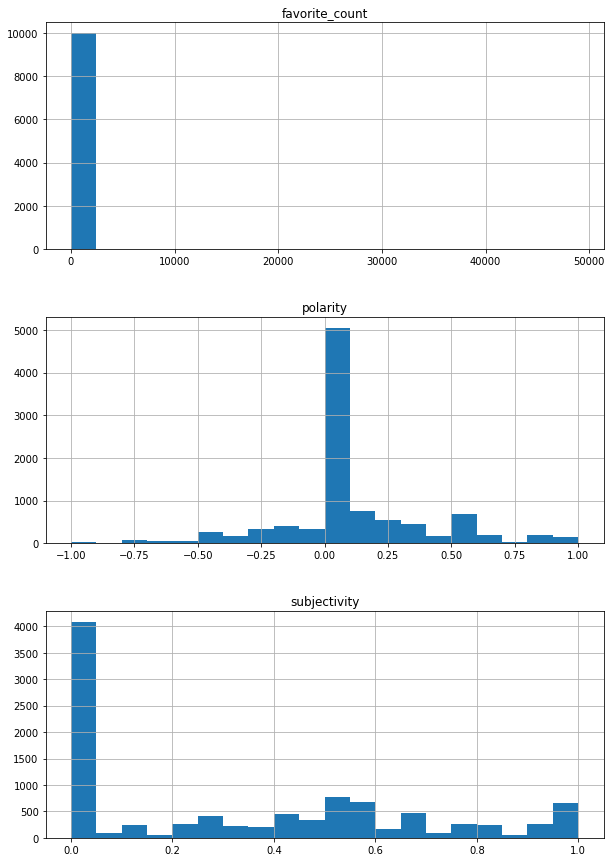

In [4]:
# Exploratory data analysis.
twitter_data.hist(bins=20, layout=(3, 1), figsize=(10,15))

In [5]:
print(twitter_data.describe())
print("\nExploring favorite_count")
print("Number of tweets over 100 likes: ", len(twitter_data[twitter_data.favorite_count>100]))
print("Number of tweets over 1000 likes: ", len(twitter_data[twitter_data.favorite_count>1000]))
print("Number of tweets over 10000 likes: ", len(twitter_data[twitter_data.favorite_count>10000]))

       favorite_count     polarity  subjectivity
count      9999.00000  9999.000000   9999.000000
mean          8.59666     0.087396      0.332452
std         514.96951     0.301567      0.338318
min           0.00000    -1.000000      0.000000
25%           0.00000     0.000000      0.000000
50%           0.00000     0.000000      0.300000
75%           0.00000     0.200000      0.600000
max       48940.00000     1.000000      1.000000

Exploring favorite_count
Number of tweets over 100 likes:  21
Number of tweets over 1000 likes:  3
Number of tweets over 10000 likes:  2


In [6]:
X = twitter_data.drop(['text', 'subjectivity'], axis = 1)
X = X.to_numpy()
y = twitter_data['subjectivity'].to_numpy()

# Split data into train and test sets using 80/20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=True, random_state=10)

## Models

SLR with polarity as explanatory variable and subjectivity as response variable


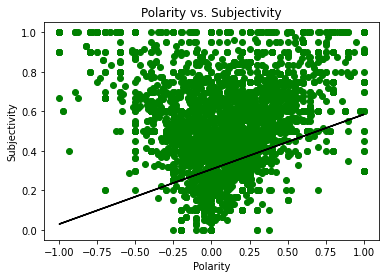

Coefficient for polarity:
 [0.27710813]
Intercept:
 0.3067854627512568
R-squared coefficient:  0.06028621850273874
Train RMSE:  0.32718447028916153
Test RMSE:  0.3279755844979715


In [7]:
# SLR with polarity as explanatory variable and subjectivity as response variabl

print("SLR with polarity as explanatory variable and subjectivity as response variable")

X_train_sent = X_train[:, 1].reshape(-1, 1)
X_test_sent = X_test[:, 1].reshape(-1, 1)

# Instantiate the model object
linreg = LinearRegression(fit_intercept = True)

# Fit the model to our dataset
linreg.fit(X_train_sent, y_train)

plt.scatter(X_train_sent, y_train,color='g')
plt.plot(X_train_sent, linreg.predict(X_train_sent),color='k')
plt.xlabel("Polarity")
plt.ylabel("Subjectivity")
plt.title("Polarity vs. Subjectivity")
plt.show()

# What coefficients do we come up with?
print('Coefficient for polarity:\n',linreg.coef_)
print('Intercept:\n', linreg.intercept_)

# What is the R^2 value of the regression?
print('R-squared coefficient: ', linreg.score(X_train_sent, y_train))


# Generate predictions from training data
y_train_sent_preds = linreg.predict(X_train_sent)

# Generate predictions from test set
y_test_sent_preds = linreg.predict(X_test_sent)

# Generate Train and Test errors
train_sent_mse = mean_squared_error(y_train, y_train_sent_preds, squared = False)
test_sent_mse = mean_squared_error(y_test, y_test_sent_preds, squared = False)

# Setting squared=False gives Root MSE
print('Train RMSE: ', train_sent_mse)
print('Test RMSE: ', test_sent_mse)

SLR with absolute value of polarity as explanatory variable and subjectivity as response variable


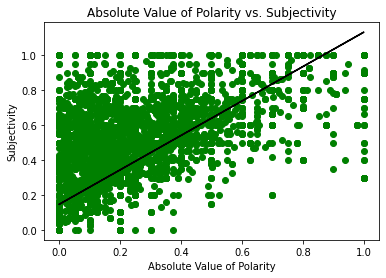

Coefficient for absolute vaule of polarity:
 [0.98498577]
Intercept:
 0.14705077022411947
R-squared coefficient:  0.5279993925491302
Train RMSE:  0.23188153282531773
Test RMSE:  0.23426203220824005


In [8]:
# SLR with absolute value of polarity as explanatory variable and subjectivity as response variable

print("SLR with absolute value of polarity as explanatory variable and subjectivity as response variable")

X_train_abs_sent = X_train[:, 1].reshape(-1, 1)
X_train_abs_sent = np.abs(X_train_abs_sent)
X_test_abs_sent = X_test[:, 1].reshape(-1, 1)
X_test_abs_sent = np.abs(X_test_abs_sent)

# Instantiate the model object
linreg = LinearRegression(fit_intercept = True)

# Fit the model to our dataset
linreg.fit(X_train_abs_sent, y_train)

plt.scatter(X_train_abs_sent, y_train,color='g')
plt.plot(X_train_abs_sent, linreg.predict(X_train_abs_sent),color='k')
plt.xlabel("Absolute Value of Polarity")
plt.ylabel("Subjectivity")
plt.title("Absolute Value of Polarity vs. Subjectivity")
plt.show()

# What coefficients do we come up with?
print('Coefficient for absolute vaule of polarity:\n',linreg.coef_)
print('Intercept:\n', linreg.intercept_)

# What is the R^2 value of the regression?
print('R-squared coefficient: ', linreg.score(X_train_abs_sent, y_train))


# Generate predictions from training data
y_train_abs_sent_preds = linreg.predict(X_train_abs_sent)

# Generate predictions from test set
y_test_abs_sent_preds = linreg.predict(X_test_abs_sent)

# Generate Train and Test errors
train_abs_sent_mse = mean_squared_error(y_train, y_train_abs_sent_preds, squared = False)
test_abs_sent_mse = mean_squared_error(y_test, y_test_abs_sent_preds, squared = False)

# Setting squared=False gives Root MSE
print('Train RMSE: ', train_abs_sent_mse)
print('Test RMSE: ', test_abs_sent_mse)

In [13]:
# Using Statsmodels and sk-learn for final models and inference
df = pd.DataFrame({'like_counts':X_train[:, 0], 'polarity':X_train[:, 1], 'abs_polarity': np.abs(X_train[:, 1]), 'sq_polarity': np.square(X_train[:, 1]), 'subjectivity':y_train})

# Quadratic regression
reg_quad = smf.ols('subjectivity~sq_polarity+polarity', data=df).fit()
print(reg_quad.summary())

# Linear regression with absolute term
reg_abs = smf.ols('subjectivity~abs_polarity', data=df).fit()
print(reg_abs.summary())

# Generative additive model
bs = BSplines(df['polarity'], df=[10], degree=[3])
reg_gam = GLMGam.from_formula('subjectivity~polarity', data=df, smoother=bs).fit()
print(reg_gam.summary())
 
# KNN Regression
knr = KNeighborsRegressor(n_neighbors=17)
knr.fit(np.array(df['polarity']).reshape(-1, 1), df['subjectivity'])

                            OLS Regression Results                            
Dep. Variable:           subjectivity   R-squared:                       0.329
Model:                            OLS   Adj. R-squared:                  0.329
Method:                 Least Squares   F-statistic:                     1965.
Date:                Fri, 09 Apr 2021   Prob (F-statistic):               0.00
Time:                        05:09:08   Log-Likelihood:                -1063.4
No. Observations:                7999   AIC:                             2133.
Df Residuals:                    7996   BIC:                             2154.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.2324      0.003     66.978      

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=17, p=2,
                    weights='uniform')

## Prediction and Results

GAM RMSE: 0.19565466224620848
Linear regression RMSE: 0.23426203220824005
KNN Regressor RMSE: 0.03703841636892215
Quadratic regression RMSE: 0.2807694224946956


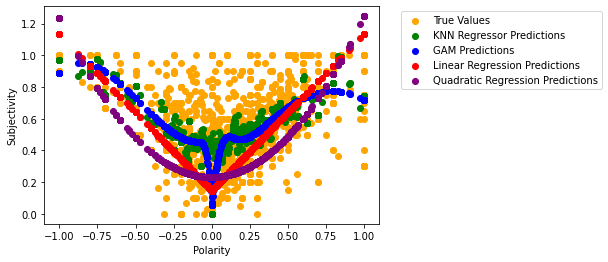

In [11]:
# Creating predictions
y_test_preds_lin = reg_abs.predict({'abs_polarity': X_test_abs_sent})
y_test_preds_knr = knr.predict(X_test_sent.reshape(-1, 1))
y_test_preds_gam = reg_gam.predict(exog_smooth=np.asarray(X_test_sent), exog={'polarity': X_test_sent})
y_test_preds_quad = reg_quad.predict({'sq_polarity': np.square(X_test_sent), 'polarity': X_test_sent})

# Calculating RMSE values
gam_rmse = mean_squared_error(y_test, y_test_preds_gam, squared=False)
quad_rmse = mean_squared_error(y_test, y_test_preds_quad, squared=False)
lin_rmse = mean_squared_error(y_test, y_test_preds_lin, squared=False)
knr_rmse = mean_squared_error(y_test, y_test_preds_knr)
print(f"GAM RMSE: {gam_rmse}")
print(f"Linear regression RMSE: {lin_rmse}")
print(f"KNN Regressor RMSE: {knr_rmse}")
print(f"Quadratic regression RMSE: {quad_rmse}")

# Plotting true values for test set
plt.scatter(X_test_sent, y_test, color="orange", label="True Values")
# Plotting predictions for KNN
plt.scatter(X_test_sent, y_test_preds_knr, color="green", label="KNN Regressor Predictions")
# Plotting predictions for GAM
plt.scatter(X_test_sent, y_test_preds_gam, color="blue", label= "GAM Predictions")
# Plotting predictions for Linear Regression with Absolute Term
plt.scatter(X_test_sent, y_test_preds_lin, color="red", label="Linear Regression Predictions")
# Plotting predictions for Quadratic Regression
plt.scatter(X_test_sent, y_test_preds_quad, color="purple", label="Quadratic Regression Predictions")
plt.xlabel("Polarity")
plt.ylabel("Subjectivity")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

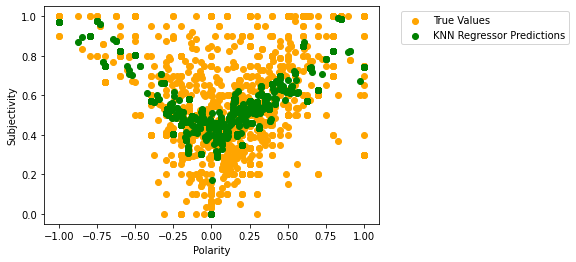

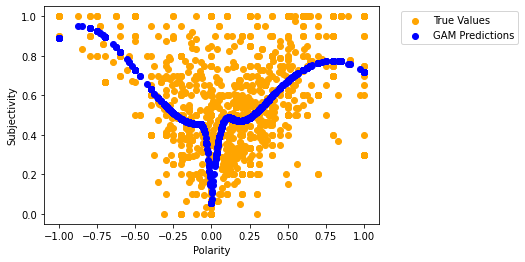

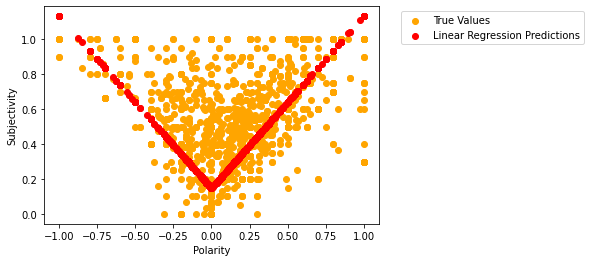

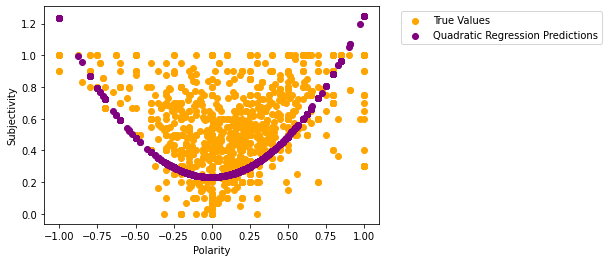

In [12]:
# Independent Plots

# Plotting predictions for KNN
plt.scatter(X_test_sent, y_test, color="orange", label="True Values")
plt.scatter(X_test_sent, y_test_preds_knr, color="green", label="KNN Regressor Predictions")
plt.xlabel("Polarity")
plt.ylabel("Subjectivity")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

# Plotting predictions for GAM
plt.scatter(X_test_sent, y_test, color="orange", label="True Values")
plt.scatter(X_test_sent, y_test_preds_gam, color="blue", label= "GAM Predictions")
plt.xlabel("Polarity")
plt.ylabel("Subjectivity")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

# Plotting predictions for Linear Regression with Absolute Term
plt.scatter(X_test_sent, y_test, color="orange", label="True Values")
plt.scatter(X_test_sent, y_test_preds_lin, color="red", label="Linear Regression Predictions")
plt.xlabel("Polarity")
plt.ylabel("Subjectivity")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

# Plotting predictions for Quadratic Regression
plt.scatter(X_test_sent, y_test, color="orange", label="True Values")
plt.scatter(X_test_sent, y_test_preds_quad, color="purple", label="Quadratic Regression Predictions")
plt.xlabel("Polarity")
plt.ylabel("Subjectivity")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()